# Trackster distances

Plot energy profiles of reco and sim tracksters.

The task gets much more difficult with the increasing overlap.

Two approaches for matching are possible:
- simtrackster that has the largest fraction of the reco trackster energy
- simtrackster in which the reco trackster makes up the largest fraction

In [33]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

from reco.plotting import plot_sim_reco, plot_tracksters, get_event_window
from reco.dataset import match_trackster_pairs, get_ground_truth
from reco.evaluation import evaluate


# %matplotlib widget
%matplotlib inline

ds_name = "MultiParticle"
ds_name = "CloseByTwoPion"

file_name = "new_ntuples_15163313_7.root"
file_name = "new_ntuples_15101852_191.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# plt.style.use('seaborn-whitegrid')

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_path: "ticlNtuplizer/graph"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

E_TH = 10 # from energy_profile

Events per file: 100


In [37]:
e_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="bary",
    confidence_threshold=0.5,
    best_only=False,
) for eid in range(ev_per_file)]

e_lc_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="pairwise",
    confidence_threshold=0.5,
    best_only=False,
) for eid in range(ev_per_file)]

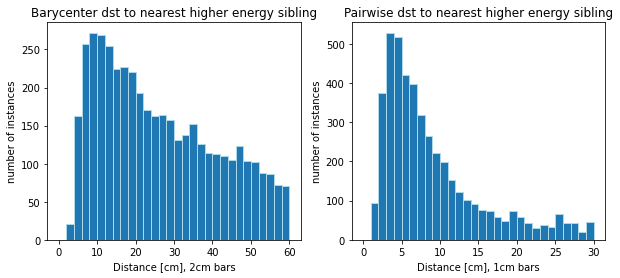

In [38]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax.hist(ak.flatten(e_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0,60))
ax.set_title("Barycenter dst to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 2cm bars")
ax.set_ylabel("number of instances")

ax = fig.add_subplot(122)
ax.hist(ak.flatten(e_lc_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0, 30))
ax.set_title("Pairwise dst to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 1cm bars")
ax.set_ylabel("number of instances")

plt.show()

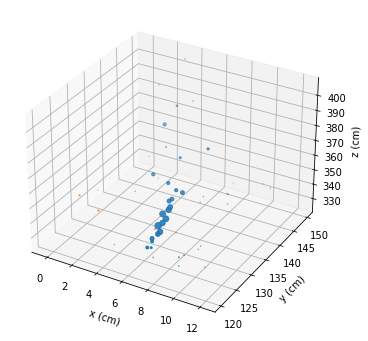

In [4]:
eid = 0
x_lc = tracksters["vertices_x"].array()[eid]
y_lc = tracksters["vertices_y"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]
e_lc = tracksters["vertices_energy"].array()[eid]

p_id = 2
indices = [p_id]
fig = plt.figure(figsize=(6, 6))

for i, (tt, lt, dst) in enumerate(e_pairs[eid]):
    if lt == p_id:
        indices.append(tt)

ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, x_lc[indices], y_lc[indices], z_lc[indices], e_lc[indices])
plt.show()

## Geometry correction

Layers further in the detector are further away from each other.

In [39]:
import pickle
from os.path import join
from reco.distance import get_z_map, apply_map

z_set = set()
sim_z_lc = tracksters["vertices_z"].array()

z_set = set(ak.flatten(sim_z_lc, axis=None))

z_list = list(sorted(z_set))
z_map = {z: i for i, z in enumerate(z_list)}


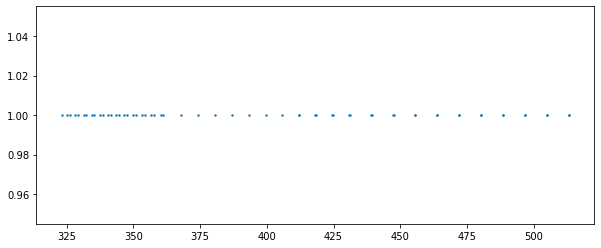

In [40]:
fig = plt.figure(figsize=(10, 4))
plt.scatter(z_list[1:], np.ones(len(z_list)-1), s=2)
plt.show()

In [41]:
# Uncomment to regenerate the map
# z_map_path = join(data_root, "z_map.pt")
# with open(z_map_path, "wb") as f:
#     pickle.dump(z_map, f)
z_map = get_z_map(data_root)

In [42]:
e_lc_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="pairwise",
    confidence_threshold=0.5,
    z_map=z_map,
    best_only=False,
) for eid in range(ev_per_file)]

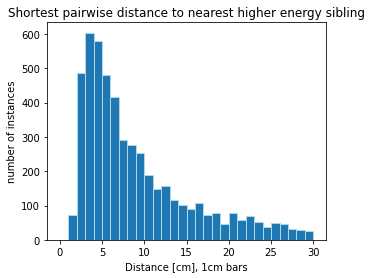

In [43]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.hist(ak.flatten(e_lc_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0, 30))
ax.set_title("Shortest pairwise distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 1cm bars")
ax.set_ylabel("number of instances")
plt.show()

## Separation of x,y and z-axis distance

Separate the distance into planear (x,y-axis) and layer-wise (z-axis) distance.

In [15]:
from reco.matching import find_good_pairs
from reco.distance import euclidian_distance
from reco.event import get_candidate_pairs_little_big, get_bary, get_candidate_pairs_direct

In [16]:
eid = 0
bary = get_bary(tracksters, eid).reshape(-1, 1, 3)
inners = graphs["linked_inners"].array()[eid]
raw_energy = tracksters["raw_energy"].array()[eid]

c_pairs, dst_map = get_candidate_pairs_direct(bary, inners, max_distance=1000)
gp = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.5)
g_pairs = list(gp)

# get barycenter distance in detector layers
a, b = g_pairs[2]

euc_d = euclidian_distance(bary[a], bary[b])
pln_d = euclidian_distance(bary[a, :, :2], bary[b, :, :2])
zax_d = abs(bary[a,0,2] - bary[b,0,2])

layers = np.array(list(z_map.keys()))

lb_a = sum(layers < bary[a, 0, 2])
lb_b = sum(layers < bary[b, 0, 2])

print("Layers before a:", lb_a)
print("Layers before b:", lb_b)

ldiff = abs(lb_a - lb_b)

print("Layers diff:", ldiff)

print(f"Euclidian distance: {euc_d:.2f} cm")
print(f"Planear distance: {pln_d:.2f} cm")
print(f"Z-distance: {zax_d:.2f} cm")

# sanity check
assert np.sqrt(pln_d**2 + zax_d**2) == euc_d

Layers before a: 35
Layers before b: 26
Layers diff: 9
Euclidian distance: 50.25 cm
Planear distance: 12.72 cm
Z-distance: 48.61 cm


In [17]:
layers = np.array(list(z_map.keys()))

planear_distance = []
layer_distance_l = []
layer_distance_cm = []

for eid in range(100):
    bary = get_bary(tracksters, eid).reshape(-1, 1, 3)
    inners = graphs["linked_inners"].array()[eid]
    raw_energy = tracksters["raw_energy"].array()[eid]

    above_threshold = np.where(raw_energy > 10)

    c_pairs, dst_map = get_candidate_pairs_little_big(bary, inners, raw_energy, max_distance=1000)
    gp = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.5)
    g_pairs = list(gp)

    closest_pairs = []

    for t_id in above_threshold[0]:
        t_id_pairs = list(filter(lambda pair: pair[1] == t_id, g_pairs))
        if t_id_pairs:
            min_pairs = list(sorted(t_id_pairs, key=lambda x: dst_map[x]))
            closest_pairs += min_pairs[:5]

    for (a, b) in closest_pairs:
        euc_d = euclidian_distance(bary[a], bary[b])
        pln_d = euclidian_distance(bary[a, :, :2], bary[b, :, :2])
        zax_d = abs(bary[a,0,2] - bary[b, 0, 2])

        lb_a = sum(layers < bary[a, 0, 2])
        lb_b = sum(layers < bary[b, 0, 2])

        ldiff = abs(lb_a - lb_b)

        planear_distance.append(pln_d)
        layer_distance_cm.append(zax_d)
        layer_distance_l.append(ldiff)

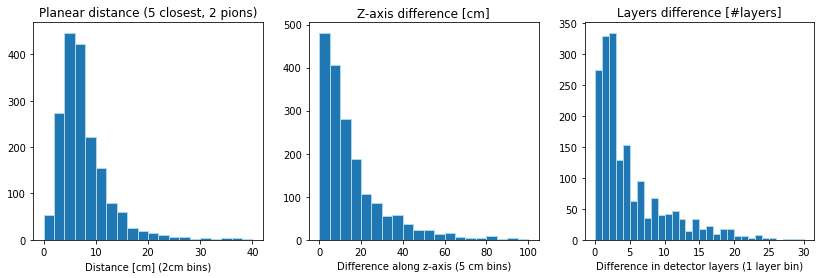

In [18]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Planear distance (5 closest, 2 pions)")
ax1.set_xlabel("Distance [cm] (2cm bins)")
ax1.hist(planear_distance, edgecolor="lightblue", bins=20, range=(0, 40))

ax2.set_title("Z-axis difference [cm]")
ax2.set_xlabel("Difference along z-axis (5 cm bins)")
ax2.hist(layer_distance_cm, edgecolor="lightblue", range=(0, 100), bins=20)

ax3.set_title("Layers difference [#layers]")
ax3.set_xlabel("Difference in detector layers (1 layer bin)")
ax3.hist(layer_distance_l, edgecolor="lightblue", range=(0, 30), bins=30)

plt.show()

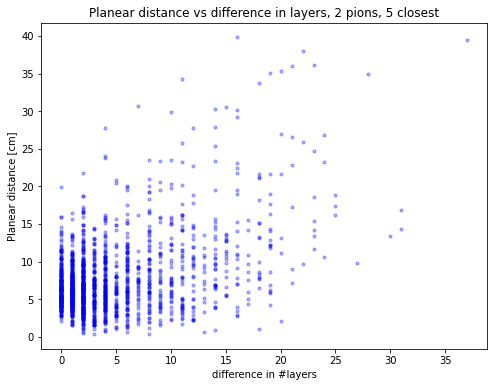

In [19]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.title("Planear distance vs difference in layers, 2 pions, 5 closest")
ax1.scatter(layer_distance_l, planear_distance, s=10, alpha=0.3, color="blue")
ax1.set_xlabel("difference in #layers")
ax1.set_ylabel("Planear distance [cm]")

plt.show()

## Pair-wise layer-cluster metrics

In [20]:
eid = 0

# get all candidates
bary = get_bary(tracksters, eid).reshape(-1, 1, 3)
c_pairs, dst_map = get_candidate_pairs_direct(bary, inners, max_distance=1000)
gp = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.5)
g_pairs = list(gp)


# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]


cloud3D = [np.array((x, y, z)).T for x, y, z in zip(vx, vy, vz)]
xy_cloud = [np.array((x, y)).T for x, y in zip(vx, vy)]

ve = tracksters["vertices_energy"].array()[eid]

inners = graphs["linked_inners"].array()[eid]
raw_energy = tracksters["raw_energy"].array()[eid]

a, b = g_pairs[1]

euc_d = euclidian_distance(cloud3D[a], cloud3D[b])
pln_d = euclidian_distance(xy_cloud[a], xy_cloud[b])

dist = []
l_dist = []
for v1 in vz[a]:
    for v2 in vz[b]:
        dist.append(abs(v1 - v2))
        l_dist.append(abs(z_map[v1] - z_map[v2]))


zax_d = min(dist)
zax_l = min(l_dist)

print(f"Min Euclidian distance: {euc_d:.2f} cm")
print(f"Min Planear distance: {pln_d:.2f} cm")
print(f"Min Z-distance: {zax_d:.2f} cm")
print(f"Min Layers-distance: {zax_l} layers")

Min Euclidian distance: 9.71 cm
Min Planear distance: 7.35 cm
Min Z-distance: 0.00 cm
Min Layers-distance: 0 layers


In [24]:
planear_distance = []
layer_distance_l = []
layer_distance_cm = []

for eid in range(ev_per_file):
    # get all candidates
    inners = graphs["linked_inners"].array()[eid]
    raw_energy = tracksters["raw_energy"].array()[eid]
    bary = get_bary(tracksters, eid).reshape(-1, 1, 3)
    c_pairs, dst_map = get_candidate_pairs_little_big(bary, inners, raw_energy, max_distance=100)
    gp = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.5)
    g_pairs = list(gp)

    # prepare distance points
    vx = tracksters["vertices_x"].array()[eid]
    vy = tracksters["vertices_y"].array()[eid]
    vz = tracksters["vertices_z"].array()[eid]

    cloud3D = [np.array((x, y, z)).T for x, y, z in zip(vx, vy, vz)]
    xy_cloud = [np.array((x, y)).T for x, y in zip(vx, vy)]

    for (a, b) in g_pairs:
        euc_d = euclidian_distance(cloud3D[a], cloud3D[b])
        pln_d = euclidian_distance(xy_cloud[a], xy_cloud[b])

        dist = []
        l_dist = []
        for v1 in vz[a]:
            for v2 in vz[b]:
                dist.append(abs(v1 - v2))
                l_dist.append(abs(z_map[v1] - z_map[v2]))


        zax_d = min(dist)
        zax_l = min(l_dist)

        planear_distance.append(pln_d)
        layer_distance_cm.append(zax_d)
        layer_distance_l.append(zax_l)

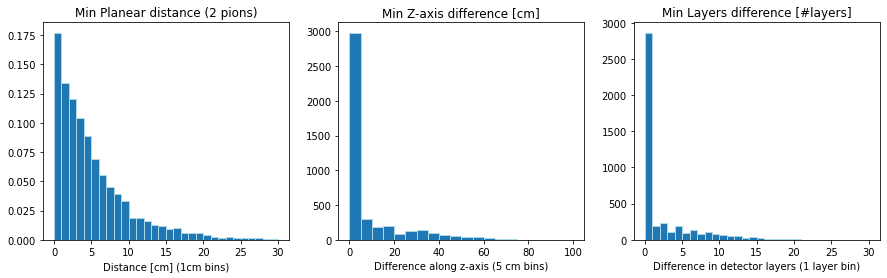

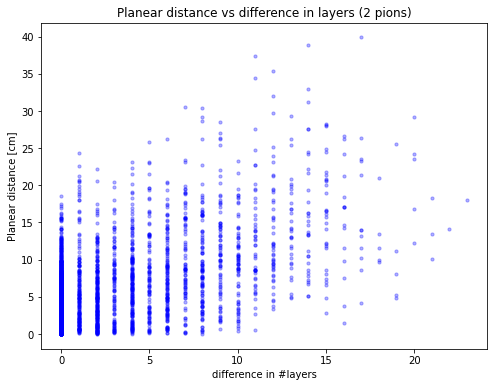

In [32]:
fig = plt.figure(figsize=(15, 4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Min Planear distance (2 pions)")
ax1.set_xlabel("Distance [cm] (1cm bins)")
ax1.hist(planear_distance, edgecolor="lightblue", bins=30, range=(0, 30), density=True)

ax2.set_title("Min Z-axis difference [cm]")
ax2.set_xlabel("Difference along z-axis (5 cm bins)")
ax2.hist(layer_distance_cm, edgecolor="lightblue", range=(0, 100), bins=20)

ax3.set_title("Min Layers difference [#layers]")
ax3.set_xlabel("Difference in detector layers (1 layer bin)")
ax3.hist(layer_distance_l, edgecolor="lightblue", range=(0, 30), bins=30)

plt.show()

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.title("Planear distance vs difference in layers (2 pions)")
ax1.scatter(layer_distance_l, planear_distance, s=10, alpha=0.3, color="blue")
ax1.set_xlabel("difference in #layers")
ax1.set_ylabel("Planear distance [cm]")

plt.show()